# Random Forest Tuning

In [1]:
from sklearn.model_selection import train_test_split

from assignment_2.digits_classifiers.model import Dataset, ClassifierTuning
from assignment_2.digits_classifiers.classifiers import RandomForest
from assignment_2.digits_classifiers.io import read_datasets
from assignment_2.digits_classifiers.utils import chunks, plot_digit

## Import dataset

In [2]:
data = read_datasets()

2022-12-22 23:33:19.973 | INFO     | assignment_2.digits_classifiers.io:read_datasets:46 - Reading datasets


In [3]:
X, y = data

## Train Test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

In [5]:
X_train

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data = Dataset(x=X, y=y)
train = Dataset(x=X_train, y=y_train)
test = Dataset(x=X_test, y=y_test)

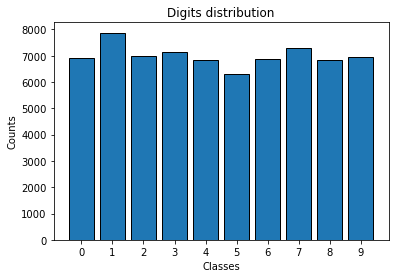

In [7]:
data.digit_distribution()

## Training Random Forest

In [8]:
forest = [
    RandomForest(train=train, test=test, params={"n_estimators": ne, "max_depth": md})
    for ne in [100, 1000, 3000]
    for md in [100, 300, 500]
]

Using small dimensionality for validation_train

In [9]:
_, X_train_cv, _, y_train_cv = train_test_split(X_train, y_train, test_size=0.50)
train_cv = Dataset(x=X_train_cv, y=y_train_cv)

In [10]:
X_train_cv.shape

(28000, 784)

In [11]:
tuning_forest = ClassifierTuning(classifiers=forest, base_estimator=RandomForest.default_estimator(), data=train_cv, k=10)
tuning_forest

[Estimator: RandomForestClassifier(); K: 10; Params: {'n_estimators': [1000, 100, 3000], 'max_depth': [100, 500, 300]}]

In [12]:
%%time
tuning_forest.evaluate()

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.96385714 0.96025    0.96382143 0.96303571 0.96003571        nan
 0.96435714 0.95989286 0.96414286]
  warnings.warn(


Wall time: 1h 30min 28s


In [13]:
tuning_forest.best_params

{'max_depth': 300, 'n_estimators': 1000}

In [14]:
tuning_forest.best_score

0.9643571428571429

In [15]:
best_forest = RandomForest(train=train, test=test, params={'n_estimators': 1000, 'max_depth': 100})
best_forest

[RandomForest: Train 56000, Test 14000, not fitted, not predicted] [N-trees: 1000; Max-depth: 100]

In [16]:
%%time
best_forest.train()

Wall time: 1min 35s


In [17]:
%%time
best_forest.predict()

Wall time: 1.61 s


In [18]:
best_forest.accuracy

0.9704285714285714

2022-12-23 01:05:33.704 | INFO     | assignment_2.digits_classifiers.model:confusion_matrix:197 - Saving C:\Users\user\Documents\GitHub\AI_assignments\assignment_2\digits_classifiers\images\random_forest_cm.png


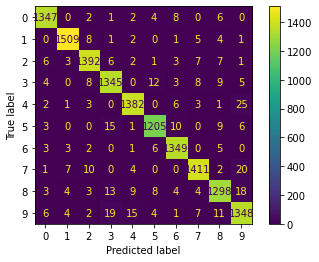

In [19]:
best_forest.confusion_matrix(save=True, file_name="random_forest_cm.png")

2022-12-23 01:05:34.407 | INFO     | assignment_2.digits_classifiers.utils:plot_digit:77 - Saving C:\Users\user\Documents\GitHub\AI_assignments\assignment_2\digits_classifiers\images\rf_feat_importance.png


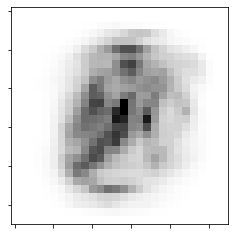

In [20]:
importance = best_forest.estimator.feature_importances_
pixels = chunks(lst=list(importance), n=28)
plot_digit(pixels=pixels, save=True, file_name='rf_feat_importance.png')

### Fool data

In [21]:
from assignment_2.digits_classifiers.io import read_fool_dataset

fool = read_fool_dataset()

In [22]:
best_forest.estimator.predict(X=fool)

array([4, 0, 0, 0, 5, 7], dtype=int64)